# Fortal Mosquito Case

- Importando bibliotecas

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils import *
from plot_path import plot_path
from show_stats import show_stats
from graph_route import plot_graph_route

import osmnx as ox
import matplotlib.pyplot as plt


ox.config(use_cache=True, log_console=True)

- Definindo País e cidade

In [3]:
city = 'Fortaleza'
country = 'Brazil'
lat_lon = (-3.72667,-38.48898)

- Filtros do OpenStreetMap

In [4]:
CUSTOM_FILTER = (
    '["highway"]["area"!~"yes"]["highway"!~"bridleway|bus_guideway|bus_stop|construction|cycleway|elevator|footway|'
    'motorway|motorway_junction|motorway_link|escalator|proposed|construction|platform|raceway|rest_area|'
    'path|service"]["access"!~"customers|no|private"]["public_transport"!~"platform"]'
    '["fee"!~"yes"]["foot"!~"no"]["service"!~"drive-through|driveway|parking_aisle"]["toll"!~"yes"]'
)

- Importando dados do OpenStreetMap via OSMnx a partir da latitude e longitude (-3.72667,-38.48898)

In [5]:
# G = ox.graph_from_place(city + ', ' + country, network_type='drive_service')
G_Org = ox.graph_from_point(lat_lon, dist=1000, custom_filter=CUSTOM_FILTER)

- Convertendo para um grafo não direcionado

In [6]:
G = ox.utils_graph.get_undirected(G_Org)

- Plotando o grafo da cidade de Fortaleza, bairro Meireles

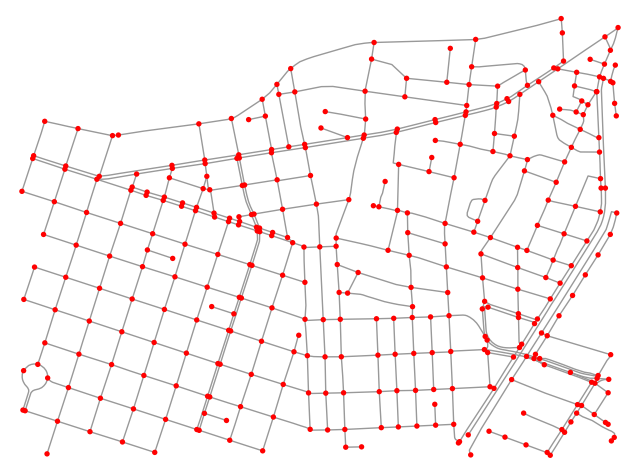

In [7]:
fig, ax = ox.plot_graph(G, node_zorder=2, node_color="r", bgcolor="w");

## Iniciando a estratégia para resolução do problema Chinese Postman

### 1. Calular a lista de nós com grau ímpar

In [8]:
odd_degree_nodes = get_odd_degree_nodes(G)

### 2. Computar todas as combinações possíveis de pares de nós com grau ímpar e calcular a menor distância entre os nós com grau ímpar

In [9]:
pair_weights = get_shortest_distance_for_odd_degrees(G, odd_degree_nodes)
matched_edges_with_weights = min_matching(pair_weights)

- Plotando o grafo com as arestas de menor distância entre os nós com grau ímpar

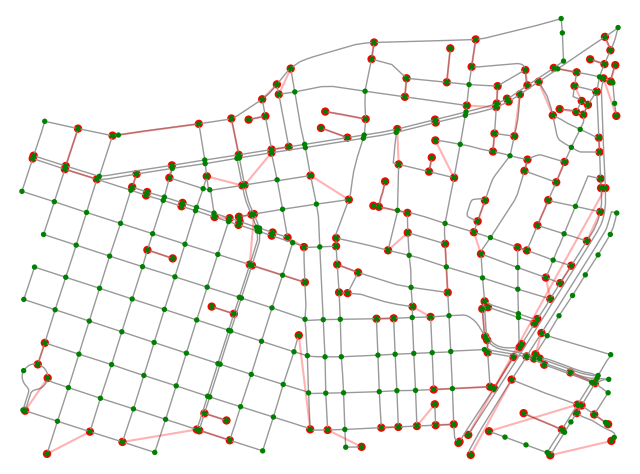

In [10]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='black', frameon=False)
for v, u, w in matched_edges_with_weights:
    x = G.nodes[v]["x"], G.nodes[u]["x"]
    y = G.nodes[v]["y"], G.nodes[u]["y"]
    ax.plot(x, y, c='red', alpha=0.3)
    ax.scatter(x, y, c='red', edgecolor="none")

fig, ax = ox.plot_graph(G, node_zorder=2, node_color='g', bgcolor='k', ax=ax)

- Calculando o menor caminho entre os nós com grau ímpar

In [11]:
added_edges = get_shortest_paths(G, matched_edges_with_weights)

### 3. Criar o grafo Euleriano completo

In [12]:
G_eulerian = nx.MultiGraph(G.copy())

for v, u in added_edges:
    G_eulerian.add_edge(v, u, trail="augmented")

print(f"Number of edges in the original graph: {len(G.edges)}")
print(f"Number of edges in the Eulerian graph: {len(G_eulerian.edges)}")

Number of edges in the original graph: 562
Number of edges in the Eulerian graph: 713


### 4. Calcular o circuito Euleriano

- Será iniciado do primeiro nó

In [13]:
first_node = list(G.edges())[0]

eulerian_path = create_eulerian_circuit(G_eulerian, G, starting_node=first_node[0])

print(f"Number of edges in the Eulerian path: {len(eulerian_path)}")

Number of edges in the Eulerian path: 713


### 5. Estatísticas do circuito Euleriano

In [14]:
show_stats(G, eulerian_path)

Comprimento do caminho: 62145.36 m
Comprimento do mapa original: 51423.89 m
Comprimento gasto refazendo arestas: 10721.47 m
Porcentagem do trajeto refeito: 20.85% 

Número de arestas no circuito: 713
Número de arestas no grafo original: 562
Número de nós no grafo original: 361

Número de arestas atravessadas mais de uma vez: 151



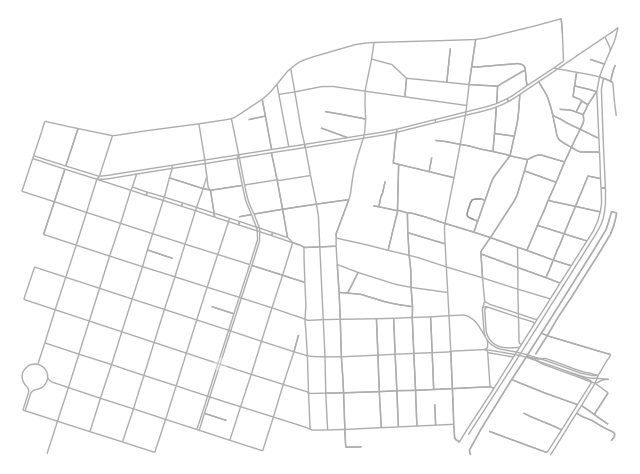

In [15]:
fig, ax = plot_graph_route(G_Org, eulerian_path, route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2, route_color="w");

- Salvando o circuito Euleriano em um arquivo .txt

In [16]:
f = open("best_path.txt", "w")

for e in eulerian_path:
    if e[2][0].get('name') is None:
        continue
    for s in (e[2][0].get('name')):
        f.write(s)
    f.write('\n')

f.close()

- Plotando o caminho no Plotly

In [17]:
route = [edge[0] for edge in eulerian_path]

lat_long = ([(G.nodes[route[i]]['y'], G.nodes[route[i]]['x']) for i in range(len(route))])


origin_point = lat_long[0]
dest_point = lat_long[-1]
lat = [x[0] for x in lat_long]
long = [x[1] for x in lat_long]

In [18]:
plot_path(lat, long, origin_point, dest_point)

- Gerando arquivo .gpx para visualização no Google Earth, Google Maps, etc.

In [19]:
from datetime import datetime
from gpx_formatter import TEMPLATE, TRACE_POINT

coordinates_path = convert_final_path_to_coordinates(G_Org, eulerian_path)

trace_points = "\n\t\t\t".join([TRACE_POINT.format(
    lat=lat, lon=lon, id=i, timestamp=datetime.now().isoformat()
) for i, (lat, lon) in enumerate(coordinates_path)])

gpx_payload = TEMPLATE.format(
    name=f"Route from {city}, {country}",
    trace_points=trace_points,
    center_lat=origin_point[0],
    center_lon=origin_point[1]
)

with open("gpx_output.gpx", "w") as f:
    f.write(gpx_payload)

### 6. Mostrando o caminho em tempo real

In [ ]:
for i, e in enumerate(eulerian_path, start=1):
    fig, ax = plot_graph_route(G_Org, eulerian_path[:i], route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2)
    ax.set_title(f"Step {i}/{len(eulerian_path)}")
    fig.savefig(f"path_img/img_{i}.png", dpi=120, bbox_inches="tight")

END